In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.IterativeFitting import IterativeFitting as IF
from src.CorrFuncs import covariance_matrix, trend_est

In [2]:
study_df = pd.read_excel("SBPvPAD_data.xlsx")

In [3]:
study_df

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
0,Stoekenbroek,114.0,21.000000,5428.500000,5449.5,1.000,1.0000,1.000,0.000000
1,Stoekenbroek,128.0,39.000000,5410.500000,5449.5,0.410,0.2200,0.590,0.093434
2,Stoekenbroek,139.0,51.000000,5398.500000,5449.5,0.440,0.2700,0.620,0.088384
3,Stoekenbroek,159.0,116.000000,5333.500000,5449.5,1.080,0.9900,1.170,0.045455
4,Itoga,123.9,249.666667,786.333333,1036.0,0.230,0.1600,0.310,0.037879
5,Itoga,129.8,249.666667,2738.333333,2988.0,1.000,1.0000,1.000,0.000000
6,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
7,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
8,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
9,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929


In [4]:
study_df["logOR"]

0    1.000
1    0.410
2    0.440
3    1.080
4    0.230
5    1.000
6   -0.062
7    0.077
8    0.110
9    0.190
Name: logOR, dtype: float64

In [5]:
study_df.iloc[0,5:8] = np.log(study_df.iloc[0,5:8].to_numpy().astype(np.float64))
study_df.iloc[5,5:8] = np.log(study_df.iloc[5,5:8].to_numpy().astype(np.float64))
study_df

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
0,Stoekenbroek,114.0,21.000000,5428.500000,5449.5,0.000,0.0000,0.000,0.000000
1,Stoekenbroek,128.0,39.000000,5410.500000,5449.5,0.410,0.2200,0.590,0.093434
2,Stoekenbroek,139.0,51.000000,5398.500000,5449.5,0.440,0.2700,0.620,0.088384
3,Stoekenbroek,159.0,116.000000,5333.500000,5449.5,1.080,0.9900,1.170,0.045455
4,Itoga,123.9,249.666667,786.333333,1036.0,0.230,0.1600,0.310,0.037879
5,Itoga,129.8,249.666667,2738.333333,2988.0,0.000,0.0000,0.000,0.000000
6,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
7,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
8,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
9,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929


In [6]:
study_df_s = study_df.loc[study_df["Author"] == "Stoekenbroek"]
study_df_i = study_df.loc[study_df["Author"] == "Itoga"]
study_df_i = study_df_i.iloc[1:,:]

In [7]:
def roll_func(study_df_j,col):
    col_s_run = []
    col = study_df_j[col].to_numpy().astype(np.float64)
    for i in range(col.shape[0]-1):
        col_s_run.append(col[i+1]-col[0])
    return np.array(col_s_run)

In [8]:
dose_s_run = roll_func(study_df_j=study_df_s, col="dose")
OR_s_rise = roll_func(study_df_j=study_df_s, col="logOR")
low_s_rise = roll_func(study_df_s,"low")
high_s_rise = roll_func(study_df_s,"high")

std_s_rise = roll_func(study_df_s, "std_error")

In [9]:
log_slopes_s = OR_s_rise / dose_s_run
low_slopes_s = low_s_rise / dose_s_run
high_slopes_s = high_s_rise / dose_s_run

std_s_rise = std_s_rise / dose_s_run

In [10]:
Sigma_s = np.diag(std_s_rise)**2
inv_Sigma_s = np.linalg.inv(Sigma_s)
beta_s = np.linalg.inv(np.ones((3,1)).T@inv_Sigma_s@np.ones((3,1)))@np.ones((3,1)).T@inv_Sigma_s@log_slopes_s

In [11]:
low_beta_s = np.linalg.inv(np.ones((3,1)).T@inv_Sigma_s@np.ones((3,1)))@np.ones((3,1)).T@inv_Sigma_s@low_slopes_s
high_beta_s = np.linalg.inv(np.ones((3,1)).T@inv_Sigma_s@np.ones((3,1)))@np.ones((3,1)).T@inv_Sigma_s@high_slopes_s

In [12]:
def create_covar_matrix(study_df,std_rise,Lx,dose_index=1):
    Nx_s = study_df["subjects"].to_numpy().astype(np.float64)
    Lx_s = study_df[Lx].to_numpy().astype(np.float64)[dose_index:]
    M1x_s = np.sum(study_df["cases"].to_numpy().astype(np.float64))
    A0_s = M1x_s*Nx_s[1:]/(Nx_s.sum())

    it_fit_ex = IF(Lx_s,A0_s,Nx_s,M1x_s)
    A_s, B_s, a0_s, b0_s = it_fit_ex.convexProgram()

    C = covariance_matrix(A_s,B_s,a0_s,b0_s,std_rise**2)
    inv_C = np.linalg.inv(C)

    return C, inv_C

In [13]:
C_s, inv_C_s = create_covar_matrix(study_df_s,std_s_rise,"logOR")

/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


In [14]:
low_C_s, low_inv_C_s = create_covar_matrix(study_df_s,std_s_rise,"low")

high_C_s, high_inv_C_s = create_covar_matrix(study_df_s,std_s_rise,"high")

In [15]:
beta_s_GL = np.linalg.inv(np.ones((3,1)).T@inv_C_s@np.ones((3,1)))@np.ones((3,1)).T@inv_C_s@log_slopes_s
low_beta_s_GL = np.linalg.inv(np.ones((3,1)).T@low_inv_C_s@np.ones((3,1)))@np.ones((3,1)).T@low_inv_C_s@log_slopes_s
high_beta_s_GL = np.linalg.inv(np.ones((3,1)).T@high_inv_C_s@np.ones((3,1)))@np.ones((3,1)).T@high_inv_C_s@log_slopes_s

In [16]:
beta_s_GL

array([0.02414612])

In [17]:
dose_i_run = roll_func(study_df_j=study_df_i, col="dose")
OR_i_rise = roll_func(study_df_j=study_df_i, col="logOR")
low_i_rise = roll_func(study_df_i,"low")
high_i_rise = roll_func(study_df_i,"high")

std_i_rise = roll_func(study_df_i, "std_error")

log_slopes_i = OR_i_rise / dose_i_run
low_slopes_i = low_i_rise / dose_i_run
high_slopes_i = high_i_rise / dose_i_run

std_i_rise = std_i_rise / dose_i_run

Sigma_i = np.diag(std_i_rise)**2
inv_Sigma_i = np.linalg.inv(Sigma_i)
beta_i = np.linalg.inv(np.ones((4,1)).T@inv_Sigma_i@np.ones((4,1)))@np.ones((4,1)).T@inv_Sigma_i@log_slopes_i

C_i, inv_C_i = create_covar_matrix(study_df_i,std_i_rise,"logOR")

beta_i_GL = np.linalg.inv(np.ones((4,1)).T@inv_C_i@np.ones((4,1)))@np.ones((4,1)).T@inv_C_i@log_slopes_i

In [18]:
log_slopes_i

array([-0.01291667,  0.00836957,  0.00791367,  0.00964467])

In [19]:
C_i

array([[4.46410700e-05, 1.97051483e-05, 1.62839694e-05, 9.57345970e-06],
       [1.97051483e-05, 1.68615370e-05, 1.08005842e-05, 6.34973910e-06],
       [1.62839694e-05, 9.57345970e-06, 1.16652950e-05, 5.24730674e-06],
       [1.08005842e-05, 6.34973910e-06, 5.24730674e-06, 4.74870311e-06]])

In [20]:
Sigma_i

array([[4.46410700e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.68615370e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.16652950e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.74870311e-06]])

In [21]:
def slope_fn(beta,x):
    return beta*x

In [22]:
x = np.linspace(115,165)

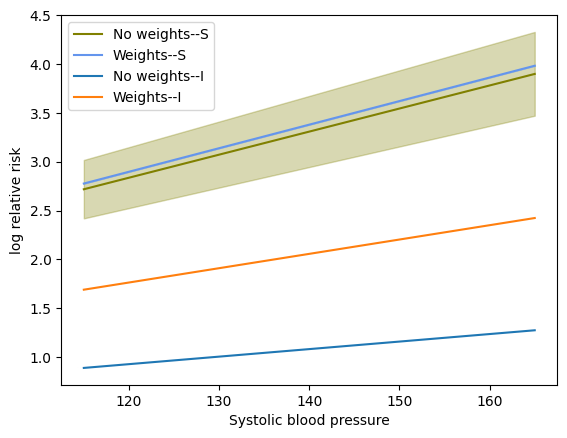

In [23]:
plt.plot(x,slope_fn(beta_s,x),label="No weights--S",c="olive")
plt.fill_between(x,slope_fn(low_beta_s,x),slope_fn(high_beta_s,x),alpha=0.3,color="olive")
plt.plot(x,slope_fn(beta_s_GL,x),label="Weights--S",c="cornflowerblue")
plt.fill_between(x,slope_fn(low_beta_s_GL,x),slope_fn(high_beta_s_GL,x),alpha=0.3,color="cornflowerblue")
plt.plot(x,slope_fn(beta_i,x),label="No weights--I")
plt.plot(x,slope_fn(beta_i_GL,x),label="Weights--I")
plt.ylabel("log relative risk")
plt.xlabel("Systolic blood pressure")
plt.legend()

#### Itoga

In [24]:
study_df_i

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
5,Itoga,129.8,249.666667,2738.333333,2988.0,0.000,0.0000,0.000,0.000000
6,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
7,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
8,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
9,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929


In [40]:
Nx_i = study_df_i["subjects"].to_numpy().astype(np.float64)
M1x_i = np.sum(study_df_i["cases"].to_numpy().astype(np.float64))
A0_i = M1x_i*Nx_i[1:]/(Nx_i.sum())
L_i = study_df_i["logOR"][1:].to_numpy()
L_i_p = L_i.copy()
L_i_p[0] = -0.062
x_i = study_df_i["dose"][1:].to_numpy()
x_i = x_i - 129.8
v_i = study_df_i["std_error"][1:].to_numpy()
v_ip = v_i.copy()
# v_ip[0] = 

it_fit_ex = IF(L_i_p,A0_i,Nx_i,M1x_i)
A_i, B_i, a0_i, b0_i = it_fit_ex.convexProgram()

C = covariance_matrix(A_i,B_i,a0_i,b0_i,v_ip**2)
inv_C_i = np.linalg.inv(C)

/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


In [41]:
A_i

array([213.99462598, 372.59450971, 352.59471619, 201.36317414])

In [42]:
a0_i

107.7863073121539

In [43]:
C

array([[0.00102853, 0.00087018, 0.00108647, 0.00090527],
       [0.00087018, 0.00142716, 0.00138118, 0.00115083],
       [0.00108647, 0.00090527, 0.00225385, 0.00143687],
       [0.00138118, 0.00115083, 0.00143687, 0.00184292]])

In [44]:
# Itoga corrected estimates
vb_star = 1/(np.dot(x_i,np.dot(inv_C_i,x_i)))
b_star = vb_star*(np.dot(x_i,np.dot(inv_C_i,L_i)))

In [45]:
b_star

0.018745169004179014

In [46]:
# Itoga unadjusted estimates
vb = 1/(np.dot(x_i,np.dot(np.linalg.inv(np.diag(v_ip)**2),x_i)))
b = vb*(np.dot(x_i,np.dot(np.linalg.inv(np.diag(v_ip)**2),L_i)))

In [47]:
b

0.0077151064467757356

There is a jump of size of order of magnitude. Why is the jump so big maybe? How do we know the difference induced by our method returns the results that are "most correct?" 

Repeat Itoga w/out negative term

In [33]:
Nx_i = study_df_i["subjects"].to_numpy().astype(np.float64)[1:]
M1x_i = np.sum(study_df_i["cases"].to_numpy().astype(np.float64)[1:])
A0_i = M1x_i*Nx_i[1:]/(Nx_i.sum())
L_i = study_df_i["logOR"][2:].to_numpy()
x_i = study_df_i["dose"][2:].to_numpy()
v_i = study_df_i["std_error"][2:].to_numpy()

it_fit_ex = IF(L_i,A0_i,Nx_i,M1x_i)
A_i, B_i, a0_i, b0_i = it_fit_ex.convexProgram()

C = covariance_matrix(A_i,B_i,a0_i,b0_i,v_i**2)
inv_C_i = np.linalg.inv(C)

In [34]:
A_i

array([322.48570552, 305.22983423, 174.39182048])

In [35]:
C

array([[0.00142716, 0.00110126, 0.00087457],
       [0.00110126, 0.00225385, 0.00108721],
       [0.00087457, 0.00108721, 0.00184292]])

In [36]:
C_nn = C
inv_C_nn = np.linalg.inv(C_nn)

In [37]:
vb_star = 1/(np.dot(x_i,np.dot(inv_C_nn,x_i)))
b_star = vb_star*(np.dot(x_i,np.dot(inv_C_nn,L_i)))
b_star

0.0008633607306968095

In [38]:
vb = 1/(np.dot(x_i,np.dot(np.linalg.inv(np.diag(v_i**2)),x_i)))
b = vb*(np.dot(x_i,np.dot(np.linalg.inv(np.diag(v_i**2)),L_i)))
b

0.000859255738818118

Ok, so now the estimates are almost exactly the same. I really think the reason behind the jump here is the fact that we have that negative in the first non-reference exposure level. But why does that make such a big difference? I'm not entirely sure.

#### Itoga simulation

In [48]:
x_i

array([ 4.8,  9.2, 13.9, 19.7])

In [49]:
beta0 = -1
beta1 = 0.2

xs = np.random.uniform(low=0,high=20,size=10000)

In [54]:
# Function to generate probabilities of being a case v non-case
p = lambda x: (np.exp(beta0 + beta1*x))/(1 + np.exp(beta0 + beta1*x))

# Actually calculating probabilities on exposures as defined
px = p(xs)

(array([ 752.,  748.,  679.,  704.,  721.,  761.,  869., 1059., 1345.,
        2362.]),
 array([0.26902336, 0.3373784 , 0.40573343, 0.47408847, 0.54244351,
        0.61079855, 0.67915358, 0.74750862, 0.81586366, 0.8842187 ,
        0.95257373]),
 <BarContainer object of 10 artists>)

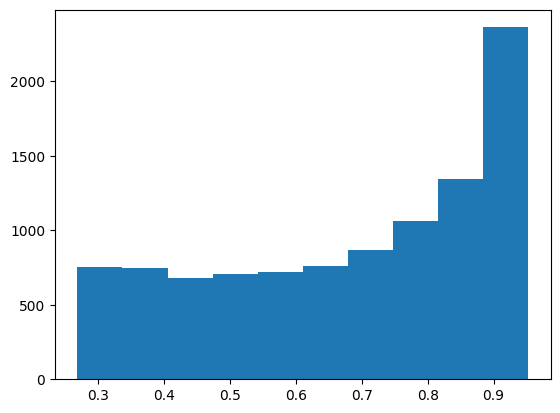

In [55]:
plt.hist(px)

In [56]:
np.max(px)

0.9525737337565566

In [57]:
# Actually assigning to case or not
outcomes = np.array([np.random.binomial(n=1,p=p,size=1)[0] for p in px])
outcomes

array([1, 1, 1, ..., 1, 0, 1])

In [58]:
# Constructing and sorting dataframe of outcomes and exposure
df = np.stack([outcomes,xs],axis=1)
df = df[np.argsort(df[:, 1])]
df

array([[0.00000000e+00, 2.08355572e-03],
       [1.00000000e+00, 4.44190513e-03],
       [0.00000000e+00, 6.09377536e-03],
       ...,
       [1.00000000e+00, 1.99973524e+01],
       [1.00000000e+00, 1.99982644e+01],
       [1.00000000e+00, 1.99999565e+01]])

In [59]:
x_i

array([ 4.8,  9.2, 13.9, 19.7])

In [61]:
# Observations at each category level
C1 = df[df[:,1] < x_i[0]]
C2 = df[np.logical_and(df[:,1] >= x_i[0], df[:,1] < x_i[1])]
C3 = df[np.logical_and(df[:,1] >= x_i[1], df[:,1] < x_i[2])]
C4 = df[np.logical_and(df[:,1] >= x_i[2], df[:,1] < x_i[3])]
C5 = df[df[:,1] >= x_i[-1]]

In [62]:
# Getting numbers of cases vs non-cases in each category
cases1 = np.sum(C1[:,0])
noncases1 = C1[:,0].shape[0] - cases1

cases2 = np.sum(C2[:,0])
noncases2 = C2[:,0].shape[0] - cases2

cases3 = np.sum(C3[:,0])
noncases3 = C3[:,0].shape[0] - cases3

cases4 = np.sum(C4[:,0])
noncases4 = C4[:,0].shape[0] - cases4

cases5 = np.sum(C5[:,0])
noncases5 = C5[:,0].shape[0] - cases5

In [67]:
# Creating a function to get crude OR estimates
crude = lambda x,y: (x/y) / (cases1/noncases1)

# Actually calculating the crude OR estimates
crudeor1 = crude(cases1,noncases1)
crudeor2 = crude(cases2,noncases2)
crudeor3 = crude(cases3,noncases3)
crudeor4 = crude(cases4,noncases4)
crudeor5 = crude(cases5,noncases5)

In [70]:
print(crudeor1,crudeor2,crudeor3,crudeor4,crudeor5)

1.0 2.614555785123967 6.271909090909091 15.716183816183817 30.777272727272727


In [75]:
# Getting categories defined
in_cat1 = np.zeros(C1.shape[0]) + 2
in_cat2 = np.zeros(C2.shape[0]) + 3
in_cat3 = np.zeros(C3.shape[0]) + 4
in_cat4 = np.zeros(C4.shape[0]) + 5
in_cat5 = np.zeros(C5.shape[0]) + 6

cats = np.append(in_cat1,in_cat2)
cats = np.append(cats,in_cat3)
cats = np.append(cats,in_cat4)
cats = np.append(cats,in_cat5)

In [76]:
cats_out_df = np.stack([df[:,0],cats], axis=1)

In [80]:
import pandas as pd
import statsmodels.api as sm

# Performing the Logit regression to recover the log odds ratios
cats_df = pd.DataFrame(cats_out_df,columns=["outcomes","categories"])
cats_df = pd.get_dummies(cats_df, columns=["categories"], dtype=np.float32)
cats_df["ones"] = np.ones(len(cats_df))
to_reg = cats_df.loc[:, [x for x in cats_df.columns if x not in ("outcomes", "categories_2.0")]]

results = sm.Logit(endog=cats_df["outcomes"], exog=to_reg).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.521969
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               outcomes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Wed, 22 May 2024   Pseudo R-squ.:                  0.1596
Time:                        21:05:56   Log-Likelihood:                -5219.7
converged:                       True   LL-Null:                       -6210.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
categories_3.0     0.9611      0.061     15.846      0.000       0.842       1.080
categories_4.0   

In [81]:
np.exp(results.params[0])

/var/folders/p0/hl6rzzgd2v5802nvrkllqms40000gp/T/ipykernel_55475/1823429862.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(results.params[0])


2.6145557851239696

In [89]:
results.params.to_numpy()

array([ 0.96109421,  1.83608079,  2.754691  ,  3.42677652, -0.50900579])

In [98]:
x = np.array([(x_i[0]+x_i[1])/2,(x_i[1]+x_i[2])/2,(x_i[2]+x_i[3])/2,(x_i[3]+20)/2])
N = np.array([cases1+noncases1,cases2+noncases2,cases3+noncases3,cases4+noncases4,cases5+noncases5])
M1 = cases1 + cases2 + cases3 + cases4 + cases5
L = results.params.to_numpy()[:-1]
v = (results.bse.to_numpy()[:-1])**2
A0 = M1*N[1:]/(N.sum())

In [99]:
it_fit_ex = IF(L,A0,N,M1)
A, B, a0, b0 = it_fit_ex.convexProgram()

C = covariance_matrix(A,B,a0,b0,v)
inv_C = np.linalg.inv(C)

/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


In [101]:
vb_star = 1/(np.dot(x,np.dot(inv_C,x)))
b_star = vb_star*(np.dot(x,np.dot(inv_C,L)))

In [102]:
b_star

0.16306420976728023

In [103]:
vb = 1/(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),x)))
b = vb*(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),L)))

In [104]:
b

0.15888570093203555

Sanity check on logit, if our estimate is actually closer than unadjusted estimate

In [105]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

x = sm.add_constant(df[:,1])
results = sm.Logit(endog=df[:,0], exog=x).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.515211
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Wed, 22 May 2024   Pseudo R-squ.:                  0.1705
Time:                        21:21:51   Log-Likelihood:                -5152.1
converged:                       True   LL-Null:                       -6210.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9684      0.046    -21.262      0.000      -1.058      -0.879
x1             0.1982      0.